# Imports

In [54]:
import pandas as pd
import numpy as np
import time

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

# Load Data

In [55]:
small_df = False
df = pd.read_csv('data/WELFake_Dataset.csv')
# df = pd.read_csv('data/kaggle.csv')


df = df.dropna(subset='title') # Remove NaN
df = df.drop_duplicates(subset='title') # Remove duplicates
df = df.reset_index(drop=True) # Reset index

# Subset of the original dataset if a smaller dataset is wanted
from math import trunc
if small_df:
    df = df.iloc[range(0, trunc(len(df['label'].values)*0.1))]

print(df['label'].value_counts())
df.head()


0    34407
1    27940
Name: label, dtype: int64


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


### Checking the maximum and minimum amount of words in the titles

In [56]:
max_len = 0
min_len = 10000
for text in df['title']:
    vec = text.split(' ')
    max_len = max(max_len, len(vec))
    min_len = min(min_len, len(vec))
print('Max word count: {}'.format(max_len),
      'Min word count: {}'.format(min_len),
      sep='\n')

Max word count: 72
Min word count: 1


### Distribution of Fake vs Real

In [57]:
nr_fake = np.sum(df['label'])
total = len(df['label'])
print('Real: {:.2f} % | Fake: {:.2f} %'.format((1-nr_fake/total)*100, (nr_fake/total)*100))

Real: 55.19 % | Fake: 44.81 %


### Split data

In [58]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
train_df, test_df = train_df.reset_index(), test_df.reset_index()
print('Training data',
      train_df['label'].value_counts(),
      '\n',
      'Testing data',
      test_df['label'].value_counts(),
      sep='\n')


Training data
0    26792
1    23085
Name: label, dtype: int64


Testing data
0    7615
1    4855
Name: label, dtype: int64


# Loading spaCy's language models

In [59]:
import spacy
nlp = spacy.load('en_core_web_sm')

TF_ENABLE_ONEDNN_OPTS=0

# Preprocess functions

In [60]:
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]


### Preprocessing data

In [36]:
x_train = [' '.join(preprocess(sent)) for sent in train_df['title']]
x_test = [' '.join(preprocess(sent)) for sent in test_df['title']]

# Naive Bayes

### Fit vectorizer

In [47]:
# TODO find out why gridsearch is not working with the tokenizer=preprocess
vect = TfidfVectorizer(max_features=2000)
vect.fit_transform(x_train)

<39901x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 251384 stored elements in Compressed Sparse Row format>

### Grid search to find best Naive Bayes classifier (for this task)

In [48]:
from sklearn.model_selection import GridSearchCV
mnb = MultinomialNB(force_alpha=True)
pipeline = Pipeline([('vectorizer', vect), ('mnb', mnb)])

alpha_values = [n / 10 for n in list(range(5, 50, 5))]
print('Testing following alpha values: {}'.format(alpha_values))
param = [{'mnb__alpha': alpha_values}]

cv = GridSearchCV(pipeline, param, n_jobs=1, verbose=1)
cv.fit(x_train, train_df['label'])

# print(pd.DataFrame(cv.cv_results_))
mnb_best = cv.best_estimator_
print(mnb_best)
y_preds = mnb_best.predict(x_test)
print(classification_report(test_df['label'], y_preds))

Testing following alpha values: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=2000)),
                ('mnb', MultinomialNB(alpha=2.5, force_alpha=True))])
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      7615
           1       0.80      0.82      0.81      4855

    accuracy                           0.85     12470
   macro avg       0.84      0.84      0.84     12470
weighted avg       0.85      0.85      0.85     12470



In [61]:
print('Accuracy: {:.2f} %'.format(100*accuracy_score(test_df['label'], y_preds)),
      'F1 score: {:.2f}'.format(f1_score(test_df['label'], y_preds)),
      sep='\n')

Accuracy: 84.96 %
F1 score: 0.81


# RNN, LSTM and BiLSTM

### Dividing train data into development data and train data

In [62]:
train_df, dev_df = train_test_split(train_df, test_size=0.2, shuffle=False)
train_df, dev_df = train_df.reset_index(), dev_df.reset_index()

print('Training data',
      train_df['label'].value_counts(),
      '\n',
      'Development data',
      dev_df['label'].value_counts(),
      sep='\n')

Training data
0    20926
1    18975
Name: label, dtype: int64


Development data
0    5866
1    4110
Name: label, dtype: int64


### Pre-process data

In [63]:
import tensorflow as tf

In [64]:
x_train = [' '.join(preprocess(sent)) for sent in train_df['title']]
x_dev = [' '.join(preprocess(sent)) for sent in dev_df['title']]
x_test = [' '.join(preprocess(sent)) for sent in test_df['title']]

### Tokenize the documments based on the training set (and padding to fixed length)

In [65]:
# Tokenizing
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x_train)
token_train = tokenizer.texts_to_sequences(x_train)
token_dev = tokenizer.texts_to_sequences(x_dev)
token_test = tokenizer.texts_to_sequences(x_test)

# Padding 
feature_size = 100
token_train = tf.keras.preprocessing.sequence.pad_sequences(token_train, feature_size)
token_dev = tf.keras.preprocessing.sequence.pad_sequences(token_train, feature_size)
token_test = tf.keras.preprocessing.sequence.pad_sequences(token_test, feature_size)

### Defining RNN

In [ ]:
# RNN
vocab_size = len(tokenizer.word_index)
embedding_vector_features = 100
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(name='inputs', shape=[feature_size]),
    tf.keras.layers.Embedding(vocab_size+1, embedding_vector_features, input_length=feature_size),
    tf.keras.layers.SimpleRNN(embedding_vector_features),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2534700   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,554,901
Trainable params: 2,554,901
Non-trainable params: 0
_________________________________________________________________
None


### Defining LSTM

In [57]:
# LSTM
vocab_size = len(tokenizer.word_index)
embedding_vector_features = 100
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(name='inputs', shape=[feature_size]),
    tf.keras.layers.Embedding(vocab_size+1, embedding_vector_features, input_length=feature_size),
    tf.keras.layers.LSTM(embedding_vector_features),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(1e-4),
                   metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1000, 100)         2534700   
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,615,201
Trainable params: 2,615,201
Non-trainable params: 0
_________________________________________________________________
None


### Defining BiLSTM

In [13]:
from tensorflow.keras.layers import Bidirectional

vocab_size = len(tokenizer.word_index)
embedding_vector_features = 100
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(name='inputs', shape=[feature_size]),
    tf.keras.layers.Embedding(vocab_size+1, embedding_vector_features, input_length=feature_size),
    Bidirectional(tf.keras.layers.LSTM(embedding_vector_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=['accuracy'])
print(model.summary())

2023-01-11 23:13:38.786821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2534700   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 2,695,701
Trainable params: 2,695,701
Non-trainable params: 0
_________________________________________________________________
None


## Train models

In [14]:
history = model.fit(token_train, train_df['label'], validation_data=(token_dev, dev_df['label']), 
                        epochs=15, 
                        batch_size=64)

Epoch 1/15
780/780 [==============================] - 56s 70ms/step - loss: 0.4862 - accuracy: 0.7456 - val_loss: 0.3152 - val_accuracy: 0.8694
Epoch 2/15
780/780 [==============================] - 55s 70ms/step - loss: 0.2729 - accuracy: 0.8887 - val_loss: 0.2576 - val_accuracy: 0.8905
Epoch 3/15
780/780 [==============================] - 55s 71ms/step - loss: 0.2191 - accuracy: 0.9135 - val_loss: 0.2466 - val_accuracy: 0.8966
Epoch 4/15
780/780 [==============================] - 55s 71ms/step - loss: 0.1900 - accuracy: 0.9260 - val_loss: 0.2423 - val_accuracy: 0.8968
Epoch 5/15
780/780 [==============================] - 55s 71ms/step - loss: 0.1671 - accuracy: 0.9377 - val_loss: 0.2473 - val_accuracy: 0.8981
Epoch 6/15
780/780 [==============================] - 55s 71ms/step - loss: 0.1478 - accuracy: 0.9452 - val_loss: 0.2515 - val_accuracy: 0.8963
Epoch 7/15
780/780 [==============================] - 56s 71ms/step - loss: 0.1342 - accuracy: 0.9512 - val_loss: 0.2642 - val_accuracy:

## Evaluate models

In [16]:
y_pred = model.predict(token_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

print(classification_report(test_df['label'], y_pred))
confusion_matrix(test_df['label'], y_pred)


390/390 [==============================] - 6s 15ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      7615
           1       0.85      0.87      0.86      4855

    accuracy                           0.89     12470
   macro avg       0.88      0.88      0.88     12470
weighted avg       0.89      0.89      0.89     12470



array([[6858,  757],
       [ 639, 4216]])

## Loss curve

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2534700   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 2,695,701
Trainable params: 2,695,701
Non-trainable params: 0
_________________________________________________________________
None


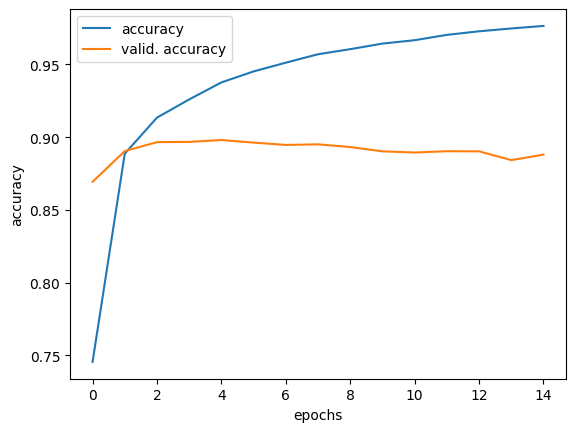

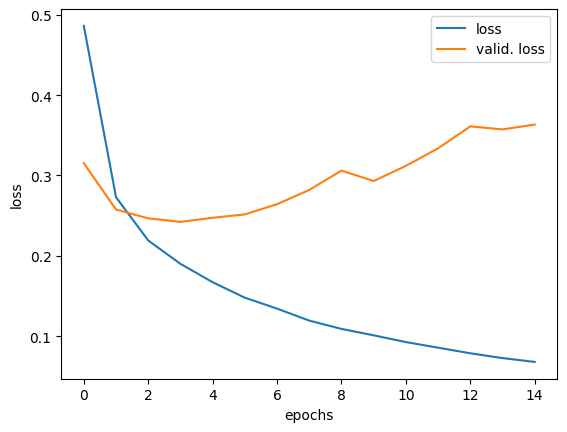

In [15]:
import matplotlib.pyplot as plt
def plot_history(history, metric):
    assert type(history) is dict, 'history needs to be a dict'
    plt.plot(history[metric])
    plt.plot(history['val_{}'.format(metric)])
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'valid. {}'.format(metric)])

plt.figure()
plot_history(history.history, 'accuracy')
plt.figure()
plot_history(history.history, 'loss')
print(model.summary())



### Save model

In [17]:
import json
def save_model(model_name, model, history):
    assert type(history) is dict, 'history needs to be a dict'
    model.save('savedmodels/models/' + model_name)
    with open('savedmodels/model_info/{}.json'.format(model_name), 'w') as f:
        json.dump(history, f)

save_model('bilstm_', model, history.history)

INFO:tensorflow:Assets written to: savedmodels/bilstm_5/assets


INFO:tensorflow:Assets written to: savedmodels/bilstm_5/assets


# Load Model for evaluation

In [71]:
model_names = ['rnn_1', 'lstm_1', 'bilstm_3']
for model_name in model_names:
      model = tf.keras.models.load_model('savedmodels/models/' + model_name)

      y_pred = model.predict(token_test)
      y_pred = np.where(y_pred >= 0.5, 1, 0)
      print(model_name)
      print('Accuracy: {:.2f}'.format(100*accuracy_score(test_df['label'], y_pred)),
            'F1 score: {:.2f}'.format(f1_score(test_df['label'], y_pred)),
            sep='\n')
      print('\n')



390/390 [==============================] - 2s 6ms/step
rnn_1
Accuracy: 88.02
F1 score: 0.85


390/390 [==============================] - 5s 11ms/step
lstm_1
Accuracy: 88.35
F1 score: 0.85


390/390 [==============================] - 7s 16ms/step
bilstm_3
Accuracy: 88.83
F1 score: 0.86


